In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [340]:
df = pd.read_csv("CleanData.csv", parse_dates=True)
df

,Date,AQI-IN,PM2.5,PM10,SO2,NO2,Temp,Humidity,O3,CO
0,2021-04-08,60.0,31.0,46.0,7.0,14.0,9.0,44.0,31.0,542.0
1,2021-04-09,147.0,70.0,79.0,6.0,19.0,10.0,39.0,39.0,618.0
2,2021-04-10,107.0,57.0,72.0,4.0,16.0,13.0,42.0,42.0,592.0
3,2021-04-11,74.0,31.0,62.0,3.0,9.0,14.0,47.0,45.0,283.0
4,2021-04-12,42.0,17.0,26.0,2.0,8.0,11.0,69.0,41.0,720.0
...,...,...,...,...,...,...,...,...,...,...
1091,2024-04-03,62.0,16.0,57.0,2.0,7.0,11.0,18.0,15.0,372.0
1092,2024-04-04,54.0,24.0,57.0,2.0,6.0,9.0,25.0,44.0,283.0
1093,2024-04-05,87.0,47.0,74.0,4.0,17.0,10.0,35.0,68.0,508.0
1094,2024-04-06,175.0,83.0,91.0,2.0,12.0,14.0,46.0,53.0,533.0


## Thêm nhãn cho chỉ số AQI

In [341]:
# Định nghĩa hàm để phân loại nhãn AQI
def classify_aqi(aqi):
    if aqi <= 50:
        return "Good" # Good
    elif aqi <= 100:
        return "Moderate"  # Moderate
    elif aqi <= 200:
        return "Poor"  # Poor
    elif aqi <= 300:
        return "Unhealthy"  # Unhealthy
    elif aqi <= 400:
        return "Severe"  # Severe
    else:
        return "Hazardous"  # Hazardous

# Thêm cột mới 'AQI_Label' vào DataFrame
df['AQI_Label'] = df['AQI-IN'].apply(classify_aqi)

df.head()

,Date,AQI-IN,PM2.5,PM10,SO2,NO2,Temp,Humidity,O3,CO,AQI_Label
0,2021-04-08,60.0,31.0,46.0,7.0,14.0,9.0,44.0,31.0,542.0,Moderate
1,2021-04-09,147.0,70.0,79.0,6.0,19.0,10.0,39.0,39.0,618.0,Poor
2,2021-04-10,107.0,57.0,72.0,4.0,16.0,13.0,42.0,42.0,592.0,Poor
3,2021-04-11,74.0,31.0,62.0,3.0,9.0,14.0,47.0,45.0,283.0,Moderate
4,2021-04-12,42.0,17.0,26.0,2.0,8.0,11.0,69.0,41.0,720.0,Good


### Ordinal Encoding

In [342]:
aqi_order = ['Good', 'Moderate', 'Poor', 'Unhealthy', 'Severe', 'Hazardous']
# Chuyển đổi thứ tự thành dạng 2D array
df['AQI_Label'] = pd.Categorical(df['AQI_Label'], categories=aqi_order, ordered=True)
label_encoder = OrdinalEncoder(categories=[aqi_order])
y_encoded = label_encoder.fit_transform(df[['AQI_Label']])
df['AQI_Ordinal_Encoded'] = y_encoded
df[['AQI_Label', 'AQI_Ordinal_Encoded']].head()


,AQI_Label,AQI_Ordinal_Encoded
0,Moderate,1.0
1,Poor,2.0
2,Poor,2.0
3,Moderate,1.0
4,Good,0.0


In [343]:
df.drop(columns=['AQI_Label'], inplace=True)
df.rename(columns={'AQI_Ordinal_Encoded': 'AQI_Label'}, inplace=True)

## Feature Transformation

### Chuẩn hoá bằng phương pháp lấy nghịch đảo

In [344]:
columns_to_inverse = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']
df_inverse_transformed = df.copy() 
df_inverse_transformed[columns_to_inverse] = 1 / df_inverse_transformed[columns_to_inverse]
df_inverse_transformed.head()

,Date,AQI-IN,PM2.5,PM10,SO2,NO2,Temp,Humidity,O3,CO,AQI_Label
0,2021-04-08,0.016667,0.032258,0.021739,0.142857,0.071429,0.111111,0.022727,0.032258,0.001845,1.0
1,2021-04-09,0.006803,0.014286,0.012658,0.166667,0.052632,0.100000,0.025641,0.025641,0.001618,2.0
2,2021-04-10,0.009346,0.017544,0.013889,0.250000,0.062500,0.076923,0.023810,0.023810,0.001689,2.0
3,2021-04-11,0.013514,0.032258,0.016129,0.333333,0.111111,0.071429,0.021277,0.022222,0.003534,1.0
4,2021-04-12,0.023810,0.058824,0.038462,0.500000,0.125000,0.090909,0.014493,0.024390,0.001389,0.0


### Chuẩn hoá bằng phương pháp Arcsine

In [345]:
columns_to_asinh = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']
df_asinh_transformed = df.copy()
df_asinh_transformed[columns_to_asinh] = np.arcsinh(df_asinh_transformed[columns_to_asinh])
df_asinh_transformed.head()

,Date,AQI-IN,PM2.5,PM10,SO2,NO2,Temp,Humidity,O3,CO,AQI_Label
0,2021-04-08,4.787561,4.127394,4.521907,2.644121,3.333478,2.893444,4.477466,4.127394,6.988414,1.0
1,2021-04-09,5.683591,4.941693,5.062635,2.491780,3.638278,2.998223,4.356873,4.356873,7.119636,2.0
2,2021-04-10,5.365998,4.736275,4.969862,2.094713,3.466711,3.259573,4.430958,4.430958,7.076655,2.0
3,2021-04-11,4.997258,4.127394,4.820347,1.818446,2.893444,3.333478,4.543408,4.499933,6.338597,1.0
4,2021-04-12,4.430958,3.527224,3.951613,1.443635,2.776472,3.093102,4.927306,4.406868,7.272399,0.0


### Chuẩn hoá bằng phương pháp Z-score

In [346]:
columns_to_zScore = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']
std_scaler_zScore = StandardScaler()
df_std_scaled_zScore = std_scaler_zScore.fit_transform(df[columns_to_zScore])
df_std_scaled_zScore = pd.DataFrame(df_std_scaled_zScore, columns=columns_to_zScore)
df_std_scaled_zScore.head()

,AQI-IN,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity
0,-0.211174,-0.003094,-0.098034,1.650945,0.246741,-0.024597,-0.236922,-0.354070,-0.932958
1,1.453082,1.650039,0.991610,1.193555,1.051110,0.606010,0.083357,-0.264799,-1.161556
2,0.687907,1.098995,0.760473,0.278774,0.568489,0.842488,-0.026212,0.003014,-1.024397
3,0.056638,-0.003094,0.430278,-0.178616,-0.557627,1.078966,-1.328398,0.092285,-0.795799
4,-0.555502,-0.596526,-0.758424,-0.636006,-0.718501,0.763662,0.513205,-0.175528,0.210035


### Chuẩn hoá bằng phương pháp Logarit

In [347]:
columns_to_log = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']
df_log_transformed = df.copy()
df_log_transformed = df[columns_to_log].apply(np.log1p)
df_log_transformed = pd.DataFrame(df_log_transformed, columns=columns_to_log)
df_log_transformed.head()

,AQI-IN,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity
0,4.110874,3.465736,3.850148,2.079442,2.708050,3.465736,6.297109,2.302585,3.806662
1,4.997212,4.262680,4.382027,1.945910,2.995732,3.688879,6.428105,2.397895,3.688879
2,4.682131,4.060443,4.290459,1.609438,2.833213,3.761200,6.385194,2.639057,3.761200
3,4.317488,3.465736,4.143135,1.386294,2.302585,3.828641,5.648974,2.708050,3.871201
4,3.761200,2.890372,3.295837,1.098612,2.197225,3.737670,6.580639,2.484907,4.248495


### Chuẩn hoá bằng phương pháp lấy căn bậc 2

In [348]:
columns_to_sqrt = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']
df_sqrt_transformed = df.copy()
df_sqrt_transformed = df[columns_to_sqrt].apply(np.sqrt)
df_sqrt_transformed = pd.DataFrame(df_sqrt_transformed, columns=columns_to_sqrt)
df_sqrt_transformed.head()

,AQI-IN,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity
0,7.745967,5.567764,6.782330,2.645751,3.741657,5.567764,23.280893,3.000000,6.633250
1,12.124356,8.366600,8.888194,2.449490,4.358899,6.244998,24.859606,3.162278,6.244998
2,10.344080,7.549834,8.485281,2.000000,4.000000,6.480741,24.331050,3.605551,6.480741
3,8.602325,5.567764,7.874008,1.732051,3.000000,6.708204,16.822604,3.741657,6.855655
4,6.480741,4.123106,5.099020,1.414214,2.828427,6.403124,26.832816,3.316625,8.306624


### Kiểm chứng dữ liệu

*Histogram so sánh biến AQI-IN trước và sau chuẩn hoá*

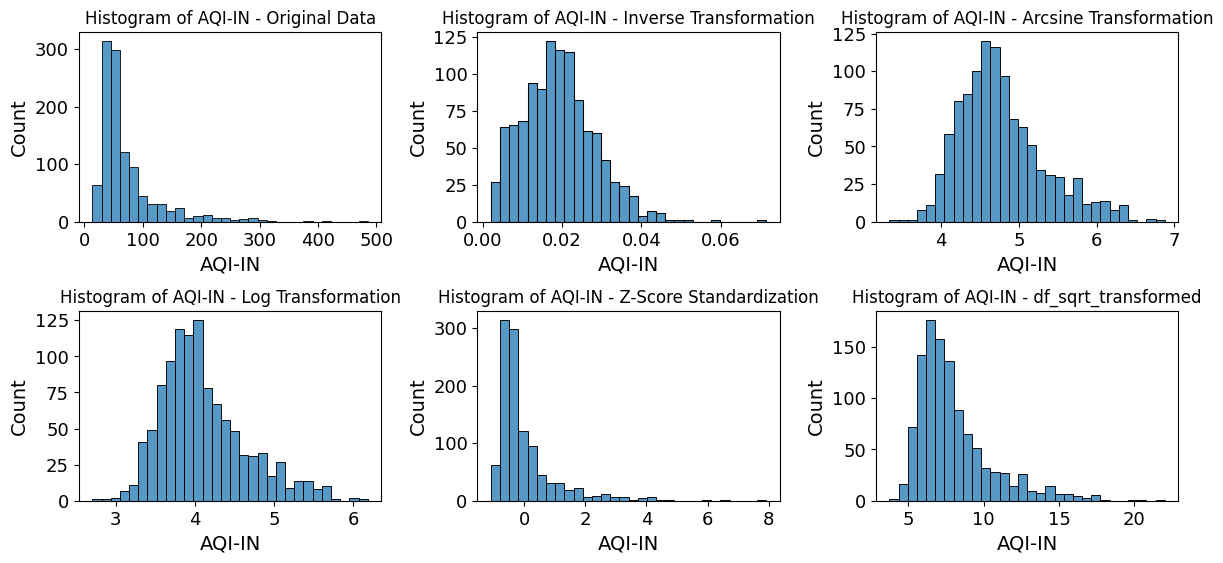

In [349]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['AQI-IN'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('AQI-IN', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of AQI-IN - {method}')
    plt.tight_layout()

plt.show()

*Sử dụng đồ thị xác suất để kiểm chứng dữ liệu sau khi biến đổi có tuân theo phân bố chuẩn*

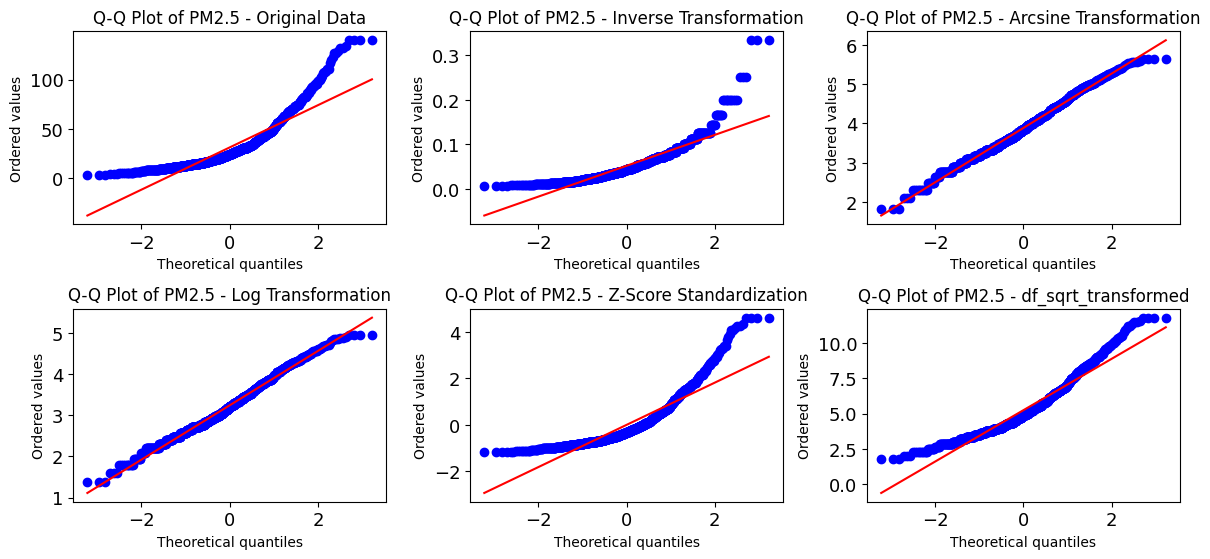

In [350]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['PM2.5'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of PM2.5 - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

#### Đặc trưng tuân theo phân bố chuẩn nhất là được chuẩn hoá bằng phương pháp Arcsine

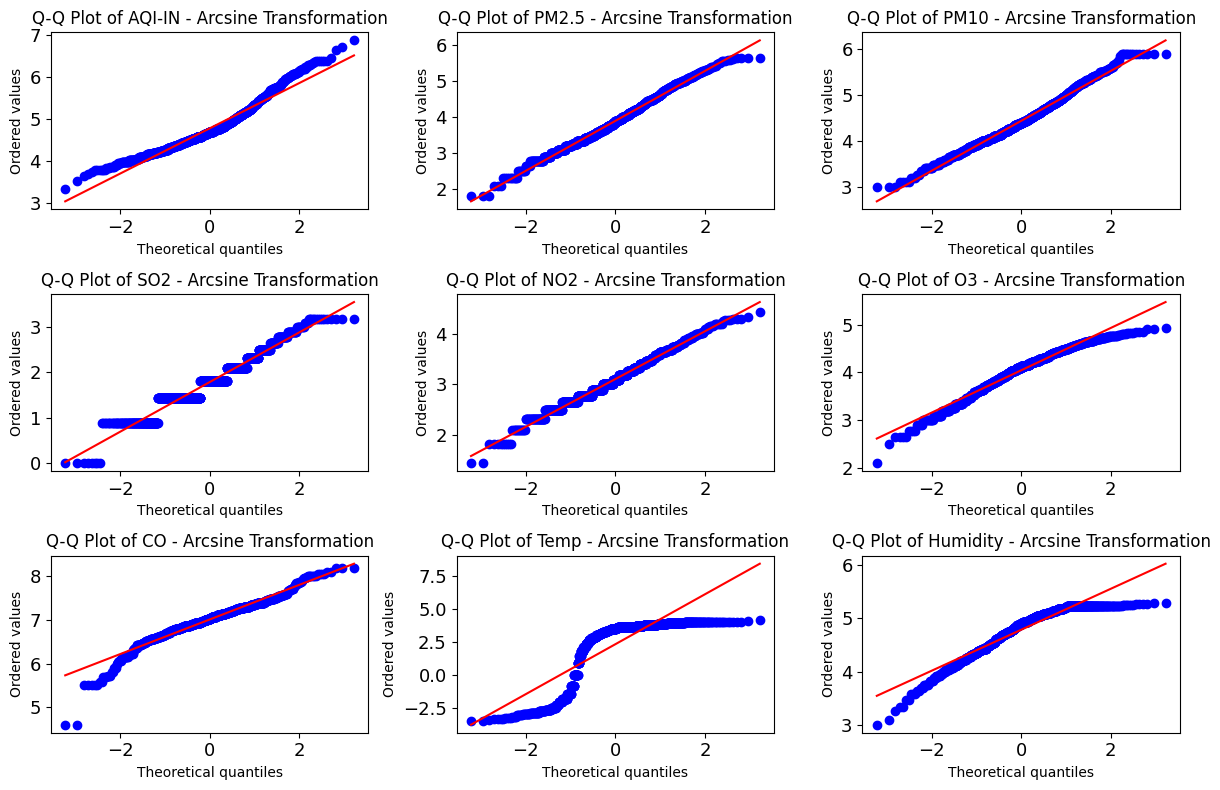

In [351]:
cols = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_asinh_transformed[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col} - Arcsine Transformation")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

<li>So sánh phân phối của đặc trưng Temp khi áp dụng các phương pháp chuẩn hoá</li>

c:\Users\DUC VAN\miniconda3\Lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


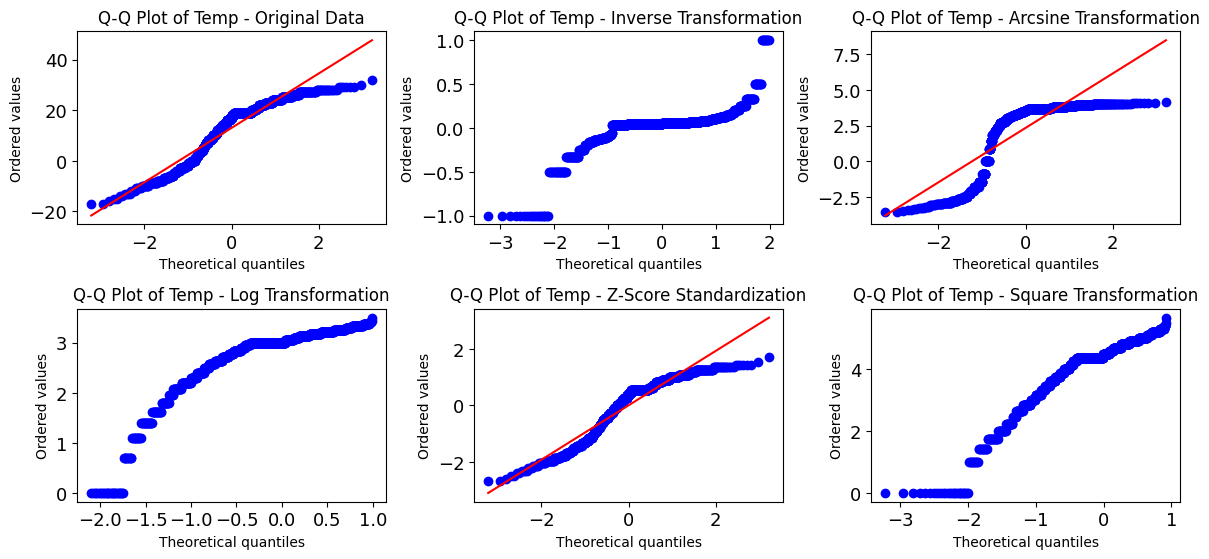

In [352]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Temp'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Temp - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

<li>So sánh phân phối của đặc trưng Humidity khi áp dụng các phương pháp chuẩn hoá</li>

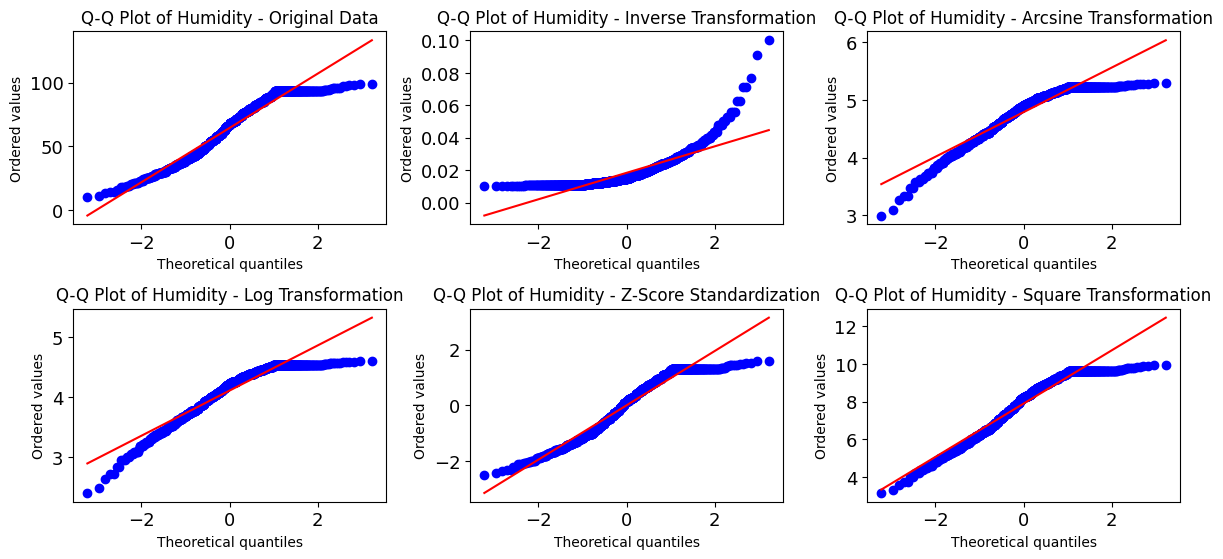

In [353]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Humidity'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Humidity - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

<li>So sánh phân phối của đặc trưng CO khi áp dụng các phương pháp chuẩn hoá</li>

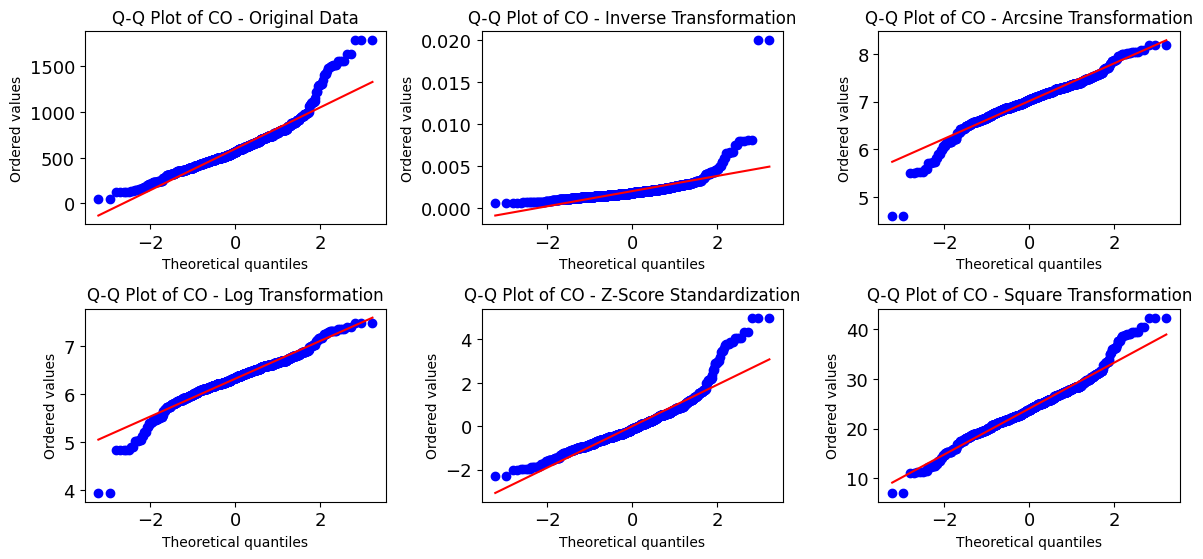

In [354]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['CO'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of CO - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

<li>So sánh phân phối của đặc trưng O3 khi áp dụng các phương pháp chuẩn hoá</li>

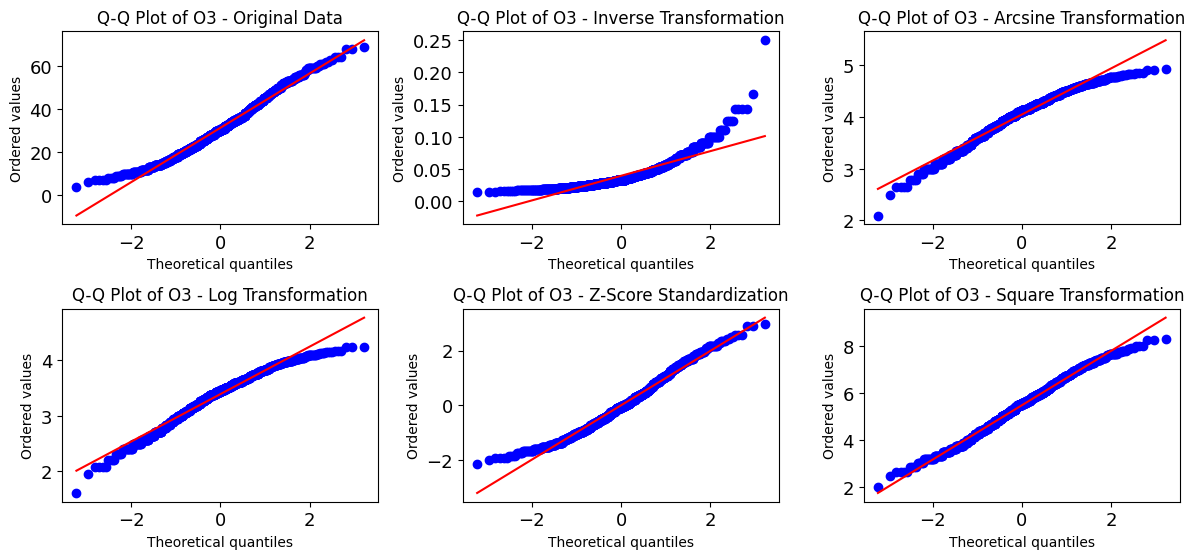

In [355]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['O3'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of O3 - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

=> Chọn phương pháp chuẩn hoá Z-Score cho đặc trưng Temp và phương pháp lấy căn bậc 2 cho đặc trưng Humidity, CO và O3

In [356]:
df_final = df[['Date']].copy() 
columns_to_asinh = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2']
df_final[columns_to_asinh] = df_asinh_transformed[columns_to_asinh]
df_final['O3'] = df_sqrt_transformed['O3']
df_final['CO'] = df_sqrt_transformed['CO']
df_final['Temp'] = df_std_scaled_zScore['Temp']
df_final['Humidity'] = df_sqrt_transformed['Humidity']
df_final['AQI_Label'] = df['AQI_Label']
df_final.head()

,Date,AQI-IN,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity,AQI_Label
0,2021-04-08,4.787561,4.127394,4.521907,2.644121,3.333478,5.567764,23.280893,-0.354070,6.633250,1.0
1,2021-04-09,5.683591,4.941693,5.062635,2.491780,3.638278,6.244998,24.859606,-0.264799,6.244998,2.0
2,2021-04-10,5.365998,4.736275,4.969862,2.094713,3.466711,6.480741,24.331050,0.003014,6.480741,2.0
3,2021-04-11,4.997258,4.127394,4.820347,1.818446,2.893444,6.708204,16.822604,0.092285,6.855655,1.0
4,2021-04-12,4.430958,3.527224,3.951613,1.443635,2.776472,6.403124,26.832816,-0.175528,8.306624,0.0


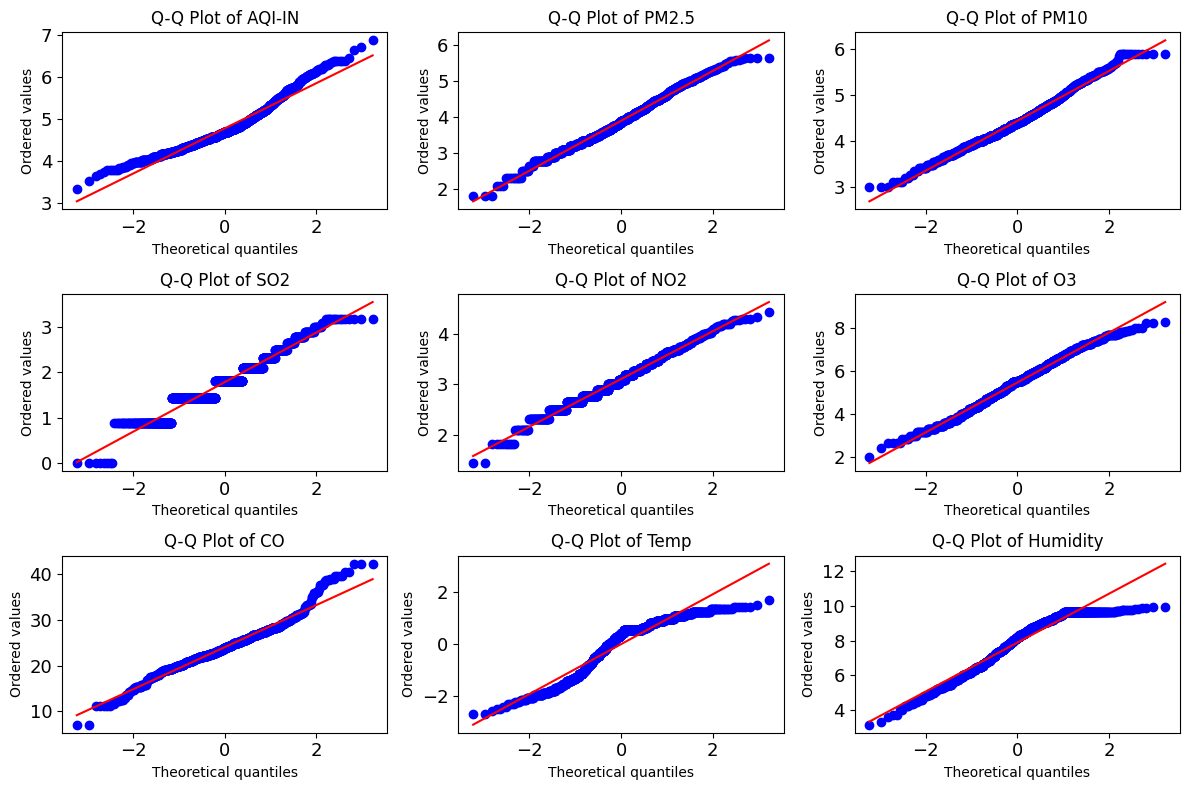

In [357]:
cols = ['AQI-IN', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'Temp', 'Humidity']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_final[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

In [358]:
df_final.to_csv('TransformedData.csv', index=False)
print("Đã xuất DataFrame ra file CSV.")

Đã xuất DataFrame ra file CSV.


## Feature selection

In [359]:
df = pd.read_csv("TransformedData.csv", parse_dates=True, index_col='Date')
df

,AQI-IN,PM2.5,PM10,SO2,NO2,O3,CO,Temp,Humidity,AQI_Label
Date,,,,,,,,,,
2021-04-08,4.787561,4.127394,4.521907,2.644121,3.333478,5.567764,23.280893,-0.354070,6.633250,1.0
2021-04-09,5.683591,4.941693,5.062635,2.491780,3.638278,6.244998,24.859606,-0.264799,6.244998,2.0
2021-04-10,5.365998,4.736275,4.969862,2.094713,3.466711,6.480741,24.331050,0.003014,6.480741,2.0
2021-04-11,4.997258,4.127394,4.820347,1.818446,2.893444,6.708204,16.822604,0.092285,6.855655,1.0
2021-04-12,4.430958,3.527224,3.951613,1.443635,2.776472,6.403124,26.832816,-0.175528,8.306624,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-03,4.820347,3.466711,4.736275,1.443635,2.644121,3.872983,19.287302,-0.175528,4.242641,1.0
2024-04-04,4.682217,3.871635,4.736275,1.443635,2.491780,6.633250,16.822604,-0.354070,5.000000,1.0
2024-04-05,5.159088,4.543408,4.997258,2.094713,3.527224,8.246211,22.538855,-0.264799,5.916080,1.0


In [360]:
X = df.drop(columns=['AQI-IN', 'AQI_Label'])
y = df["AQI-IN"]
y_label = df['AQI_Label']

### Trực quan hóa thủ công

#### Mối quan hệ của Biến Mục Tiêu với Các biến đầu vào

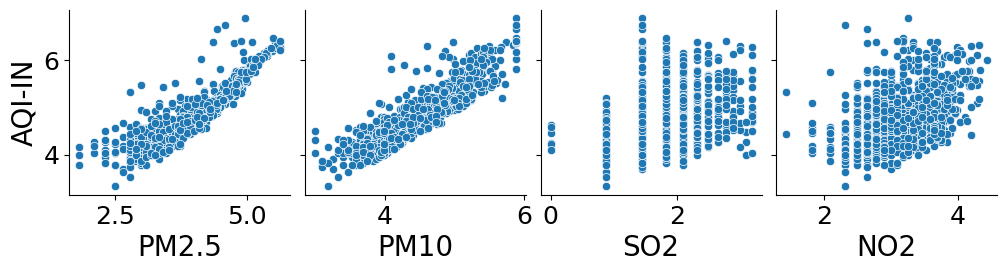

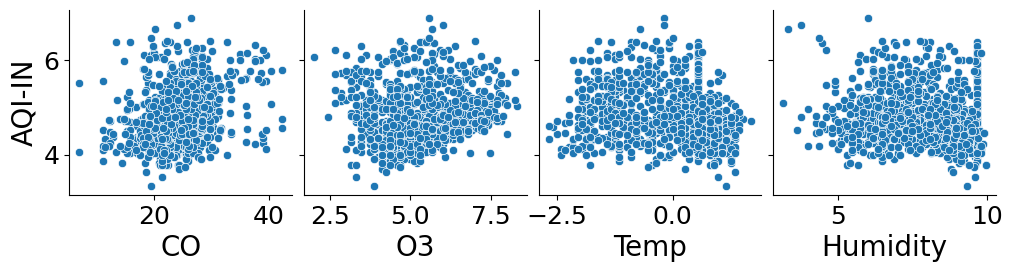

In [361]:
feature_groups = [['PM2.5', 'PM10', 'SO2', 'NO2'], ['CO', 'O3', 'Temp', 'Humidity']]

for features in feature_groups:
    pairplt_trans = sns.pairplot(df, x_vars=features, y_vars=['AQI-IN'])

    for ax in pairplt_trans.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18) 

plt.show()


* Nhận thấy rằng, biến mục tiêu AQI-IN chịu ảnh hưởng bởi biến PM2.5, PM10, SO2, NO2, O3 nhiều hơn các chỉ số còn lại.
* Chỉ số PM2.5, PM10, NO2, CO càng tăng thì Chỉ số AQI-IN càng lớn và ngược lại.

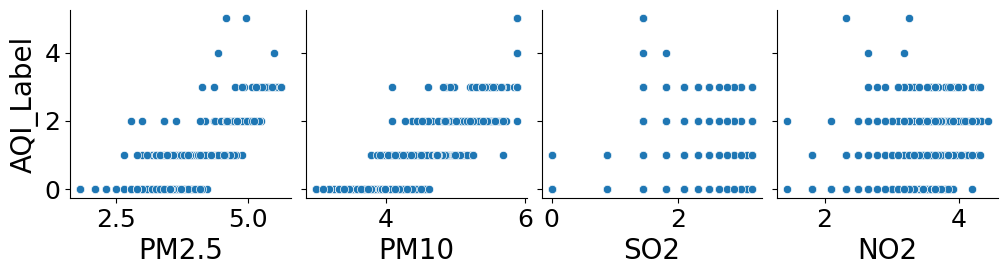

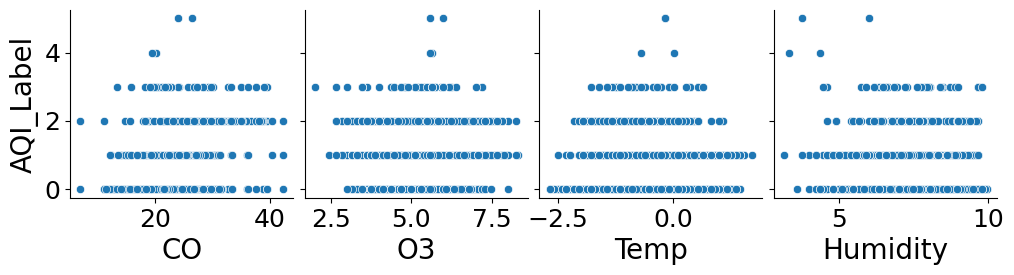

In [371]:
feature_groups = [['PM2.5', 'PM10', 'SO2', 'NO2'], ['CO', 'O3', 'Temp', 'Humidity']]

for features in feature_groups:
    pairplt_trans = sns.pairplot(df, x_vars=features, y_vars=['AQI_Label'])

    for ax in pairplt_trans.axes.flat:
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18) 

plt.show()

#### Tần suất của các nhãn AQI

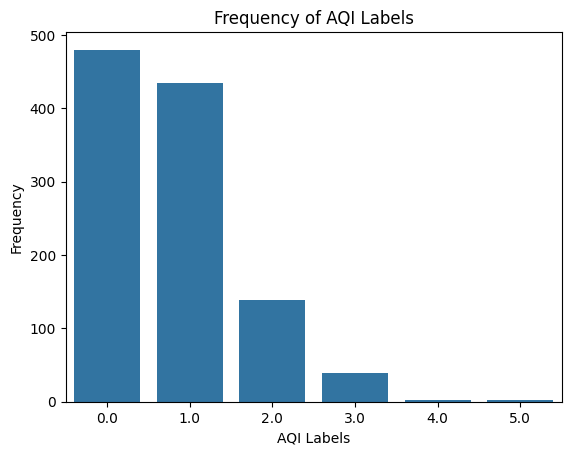

In [363]:
sns.countplot(x='AQI_Label', data=df)
plt.title('Frequency of AQI Labels')
plt.xlabel('AQI Labels')
plt.ylabel('Frequency')
plt.show()

#### Mối quan hệ giữa Các biến đầu vào

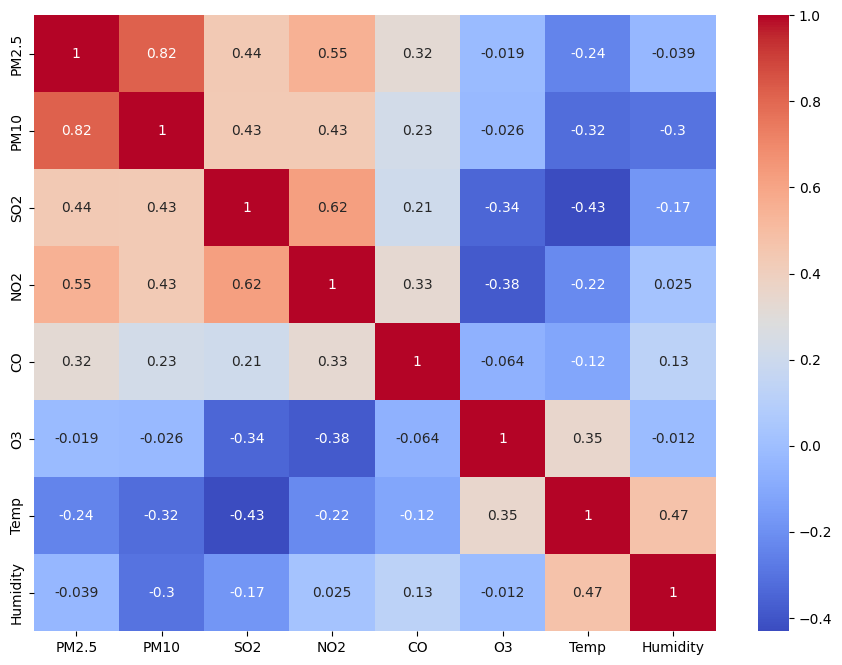

In [364]:
cols_to_include = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'Temp', 'Humidity']
plt.figure(figsize=(11, 8))
sns.heatmap(df[cols_to_include].corr(), annot=True, cmap='coolwarm')

plt.show()

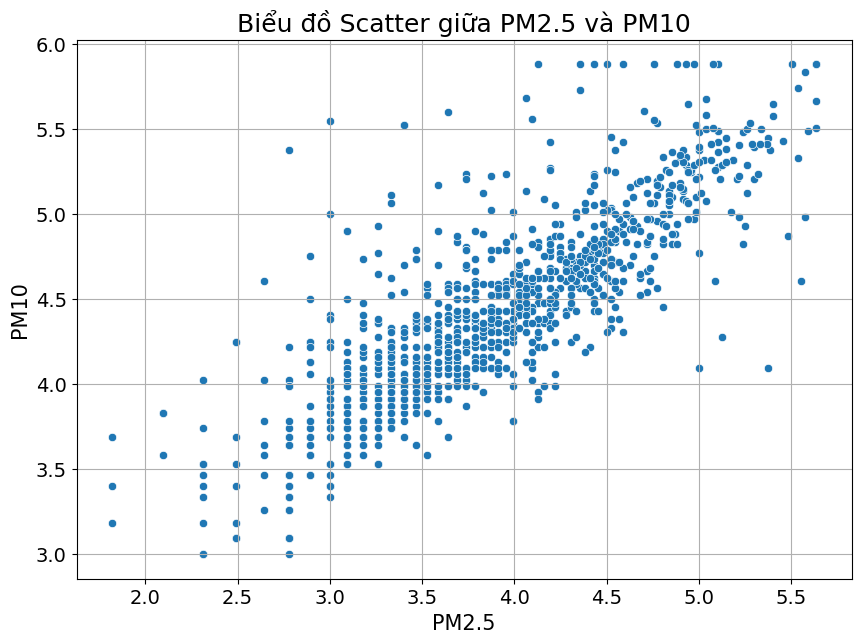

In [365]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PM2.5', y='PM10', data=df)
plt.title('Biểu đồ Scatter giữa PM2.5 và PM10', fontsize=18)
plt.xlabel('PM2.5', fontsize=15)
plt.ylabel('PM10', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

##### Kết luận:
Độ tương quan 2 biến PM2.5 và PM10 tương đối cao (0.82). Vì vậy chỉ nên giữ lại 1 trong 2 biến trong các features để phục vụ cho bước training model

### Phương pháp thống kê

#### Univariate feature selection

In [366]:
selector_best = SelectKBest(score_func=mutual_info_regression, k=8)
X_kbest = selector_best.fit_transform(X, y)
selected_features = X.columns[selector_best.get_support()]
scores = selector_best.scores_

sorted_indices = np.argsort(scores)[::-1]

print("Các đặc trưng đã chọn theo thứ tự từ tốt nhất đến kém tốt hơn:")
for index in sorted_indices:
    print(f"{selected_features[index]}: {scores[index]}")


Các đặc trưng đã chọn theo thứ tự từ tốt nhất đến kém tốt hơn:
PM2.5: 1.2400606880336569
PM10: 0.9546022487392101
O3: 0.23981054330194196
NO2: 0.14926857589294062
SO2: 0.12328451230185067
Humidity: 0.1013842823891542
Temp: 0.09958513907135558
CO: 0.05123331979361678


##### Kết luận:
Đối với phương pháp thống kê, nhờ sử dụng cách áp dụng kiểm định thống kê đơn biến mà có thể sắp xếp được thứ tự các biến từ quan trọng đến kém quan trọng nhất. Biến PM2.5 được chấm là biến quan trọng nhất trong các biến đầu vào

### Recursive feature elimination

#### Recursive feature elimination with cross-validation

In [367]:
min_features_to_select = 1
regressor = LinearRegression()

cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=regressor,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

Optimal number of features: 6
Selected features: Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'Temp'], dtype='object')


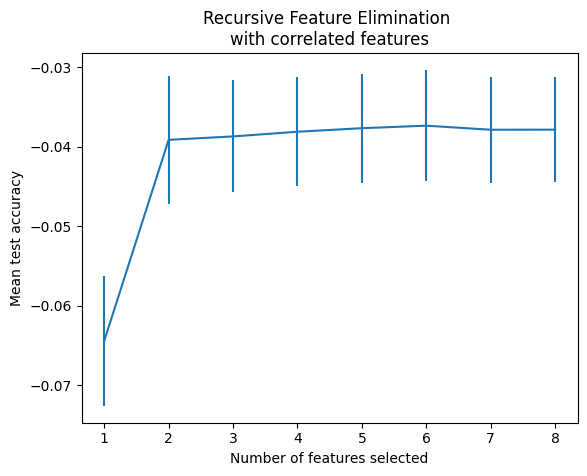

In [368]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

# Kết luận